# Import libraries and data

In [1]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as keras_image


from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

import pickle

In [3]:
import glob
import cv2

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # le.classes_
folders = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

X_init = []
y_init = []

for folder in folders:
    path = 'data\\' + folder + '\\*.jpg'
    files = glob.glob(path)

    for file in files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_init.append(img)
        y_init.append(folder)
print('Count of images:', len(X_init))

Count of images: 2251


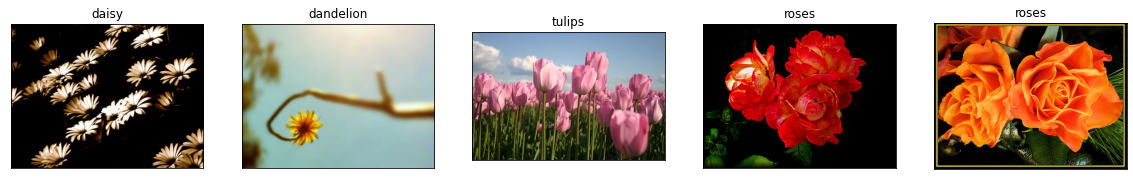

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def plot_sample(X, y, is_gray = False):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    idxs = np.random.randint(0, len(X), size=5)

    for i, idx in enumerate(idxs):
        img = X[idx]
        ax = axs[i]
        if is_gray:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        label = ""
        if isinstance(y, list):
            label = y[idx]
        else:
            label = CLASS_NAMES[y[idx].argmax()]
        ax.set_title(label)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plot_sample(X_init, y_init)

# Prepocessing data and splitting dataset

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y_init).reshape(-1, 1)
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
y_one_hot = enc.fit_transform(y_encoded)
y = np.array(y_one_hot.toarray())

In [8]:
dim = (128, 128)
def preprocess(X_init):
    X = []
    for i in range(len(X_init)):
        img = X_init[i].copy()
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = img / 255
        X.append(img)
    return X

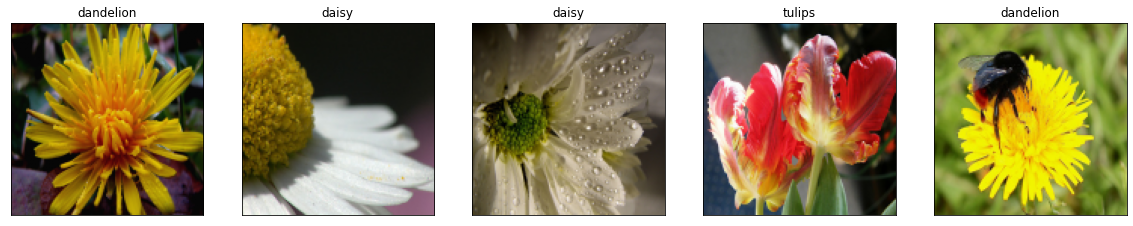

In [9]:
X = preprocess(X_init)
X = np.array(X)
plot_sample(X, y)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) # split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0) # split data
print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1822
Val size: 203
Test size: 226


In [29]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)
aug_iter = data_generator.flow(X_train, y_train)

In [31]:
X_train_aug = []
y_train_aug = []
for i in range(len(aug_iter)):
    it = next(aug_iter)
    for idx in range(it[0].shape[0]):
        X_train_aug.append(it[0][idx])
        y_train_aug.append(it[1][idx])
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
print(X_train_aug.shape)
print(y_train_aug.shape)

(1822, 128, 128, 3)
(1822, 5)


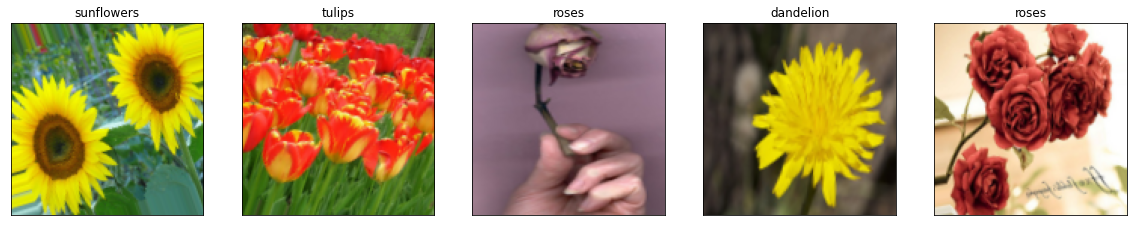

In [32]:
plot_sample(X_train_aug, y_train_aug)

# Models

## Utilities & Consts

In [33]:
BATCH_SIZE = 64
EPOCHS = 2
VALIDATION_SPLIT = 0.1
CLASS_NUM = 5
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [34]:
def show_confusion_matrix(y_test, y_pred, in_prob = True, labels = [], ax = None):
    # y_test & y_pred should be in the same format
    # in_prob == False implies that we get something like [2, 2, 3, 0, ...] where 2, 2... are numbers of class
    # in_prob = True implies that models might give probabilities therefore we need to extract the most possible class
    if(in_prob):
        y_pred = np.argmax(y_pred, axis=1).T
        y_test = np.argmax(y_test, axis=1).T
        
    cf_matrix = confusion_matrix(y_test, y_pred)
    if(ax is None):
        fig, ax = plt.subplots(1, 1, figsize=(16, 4))
        
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.2f', square=True, ax=ax)
    
    if len(labels) != 0:
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
    ax.set_title("Confusion matrix")
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

# Example
#show_confusion_matrix(y_test, y_pred, True, labels = CLASS_NAMES)

## CNN

In [99]:
def train_save_evaluate(model_func, path, X_train, y_train, X_val, y_val, X_test, y_test):
    model = model_func()
    model.summary()
    
    # train
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))
    
    # evaluate
    eval = model.evaluate(X_test, y_test)
    print("Loss: " + str(eval[0]) + " Accuracy: " + str(eval[1]))

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    ax = axs[0]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')

    ax = axs[1]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    
    ax = axs[2]
    y_pred = model.predict(X_test)
    show_confusion_matrix(y_test, y_pred, True, labels = CLASS_NAMES, ax=ax)
    
    # save
    model.save(path)
    model = tf.keras.models.load_model(path)
    
    return model

def inference_cnn(model, imgs):
    pred = []
    dim = (128, 128)
    for img in imgs:
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        img = img / 255
        img = np.expand_dims(img, axis=0)
        pred.append(model.predict(img))
    pred = np.array(pred)
    pred = pred.reshape(len(imgs), 5)
    return pred

def plot_inference(inference_func, model, imgs, y_test, cols = 5, with_prob = False):
    y_pred_prob = inference_func(model, imgs)
    y_pred = np.argmax(y_pred_prob, axis=1).T
    #y_test = np.argmax(y_test, axis=1).T
    
    n = len(imgs)
    k = 2 if with_prob else 1
    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(k * rows, cols, figsize=(24, 6 * k * rows))
    for ax in axs.ravel(): # remove ticks from all canvas
        ax.set_xticks([])
        ax.set_yticks([])
    for i, img in enumerate(imgs):
        if with_prob:
            ax = axs[k * (i // cols) + 1, i % cols]
            #y_pos = np.arange(len(CLASS_NAMES))
            ax.barh(CLASS_NAMES, y_pred_prob[i])
            #ax.set_yticks(labels=CLASS_NAMES)
            ax.set_xlabel('Probability')
            
        ax = axs[k * (i // cols), i % cols]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        s = "Actual: " + y_test[i] + "\nPredicted: " + CLASS_NAMES[y_pred[i]]
        ax.set_title(s)
        
        # borders
        color = 'red'
        if y_test[i] == CLASS_NAMES[y_pred[i]]:
            color = 'limegreen'
            
        ax.spines['bottom'].set_color(color)
        ax.spines['bottom'].set_linewidth(6)
        ax.spines['top'].set_color(color)
        ax.spines['top'].set_linewidth(6)
        ax.spines['right'].set_color(color)
        ax.spines['right'].set_linewidth(6)
        ax.spines['left'].set_color(color)
        ax.spines['left'].set_linewidth(6)

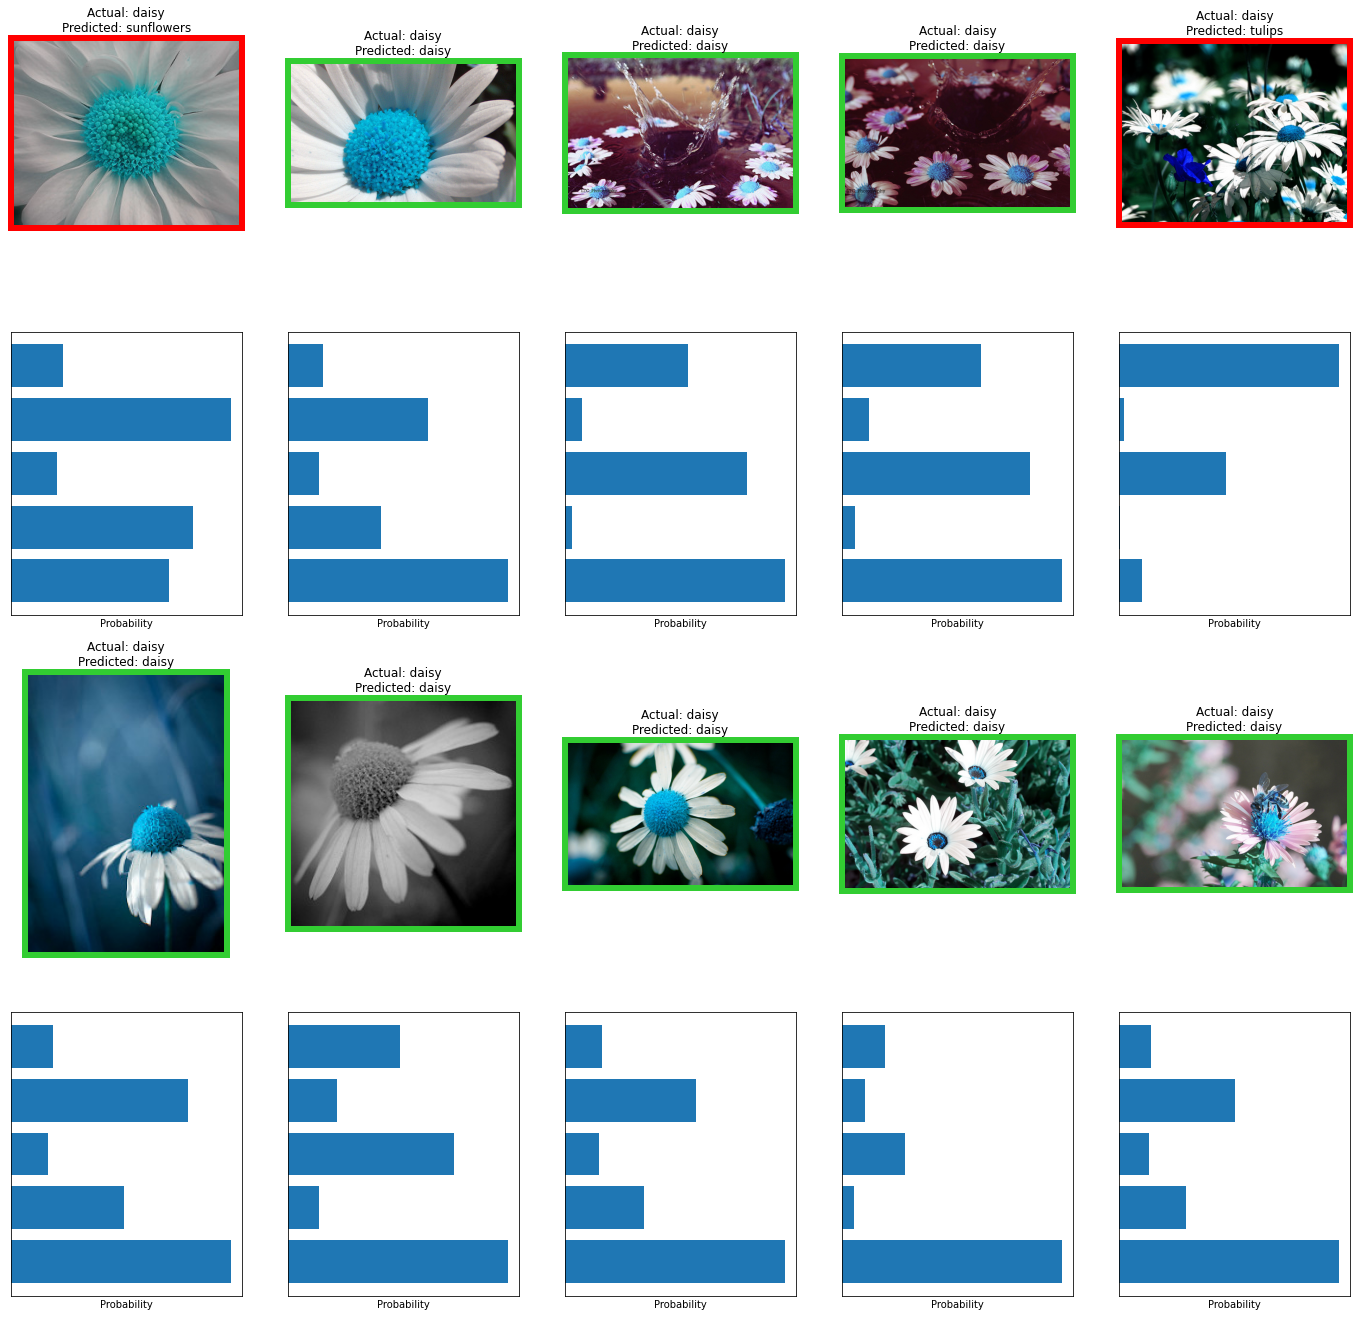

In [100]:
imgs = X_init[:10]
y_test_imgs = y_init[:10]
plot_inference(inference_cnn, model, imgs, y_test_imgs, with_prob = True)

In [ ]:
def plot_inference(inference_func, model, imgs, y_test, cols = 5, with_prob = False):
    y_pred = inference_func(model, imgs)
    y_pred = np.argmax(y_pred, axis=1).T
    #y_test = np.argmax(y_test, axis=1).T
    
    n = len(imgs)
    k = 2 if with_prob else 1
    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(k * rows, cols, figsize=(24, 6 * k * rows))
    for ax in axs.ravel(): # remove ticks from all canvas
        ax.set_xticks([])
        ax.set_yticks([])
    for i, img in enumerate(imgs):
        if with_prob:
            ax = axs[k * (i // cols) + 1, i % cols]
            #print(image.ndim)
            #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.hist(img.ravel())
            
        ax = axs[k * (i // cols), i % cols]
        
        ax = axs[i // cols, i % cols]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        s = "Actual: " + y_test[i] + "\nPredicted: " + CLASS_NAMES[y_pred[i]]
        ax.set_title(s)
        
        # borders
        color = 'red'
        if y_test[i] == CLASS_NAMES[y_pred[i]]:
            color = 'limegreen'
            
        ax.spines['bottom'].set_color(color)
        ax.spines['bottom'].set_linewidth(6)
        ax.spines['top'].set_color(color)
        ax.spines['top'].set_linewidth(6)
        ax.spines['right'].set_color(color)
        ax.spines['right'].set_linewidth(6)
        ax.spines['left'].set_color(color)
        ax.spines['left'].set_linewidth(6)

In [36]:
def model_1():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(CLASS_NUM))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                        

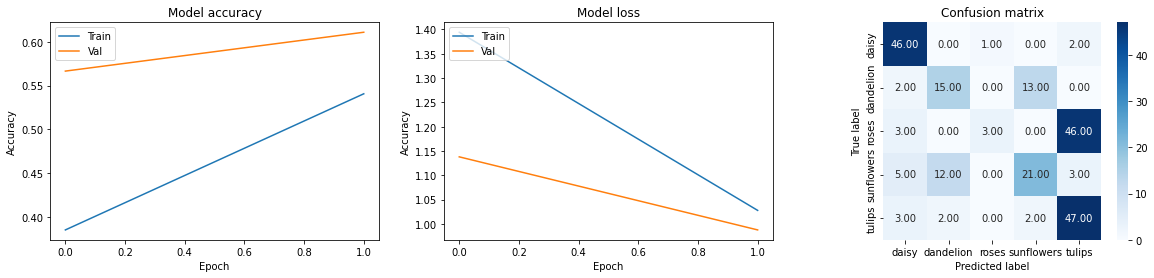

In [37]:
model = train_save_evaluate(model_1, 'models\CNN_01.h5', X_train_aug, y_train_aug, X_val, y_val, X_test, y_test)

In [13]:
def model_2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(CLASS_NUM,  activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [15]:
model = train_save_evaluate(model_2, 'models\CNN_02.h5', X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/2
26/26 [==============================] - 62s 2s/step - loss: 1.5281 - accuracy: 0.3209 - val_loss: 1.3565 - val_accuracy: 0.3388
Epoch 2/2
26/26 [==============================] - 67s 3s/step - loss: 1.1270 - accuracy: 0.5351 - val_loss: 1.1400 - val_accuracy: 0.4863


## Pretrained model

In [19]:
dim1 = X_train[0].shape[0] # image width
dim2 = X_train[0].shape[1] # image height 
dim3 = 3 # image channels

In [14]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()

In [23]:
from keras.applications.vgg16 import VGG16


In [12]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(include_top=False, input_shape=(dim1, dim2, dim3))
model.trainable=False
#flat1 = Flatten()(model.layers[-1].output)
flat1 = tf.keras.layers.GlobalAveragePooling2D()(model.layers[-1].output)
#class1 = Dense(10, activation='relu')(flat1)
class1 = flat1
output = Dense(5, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                              

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/10
29/29 [==============================] - 48s 1s/step - loss: 1.4081 - accuracy: 0.5285 - val_loss: 0.8256 - val_accuracy: 0.7094
Epoch 2/10
29/29 [==============================] - 40s 1s/step - loss: 0.6086 - accuracy: 0.7651 - val_loss: 0.6170 - val_accuracy: 0.7488
Epoch 3/10
29/29 [==============================] - 41s 1s/step - loss: 0.4655 - accuracy: 0.8282 - val_loss: 0.5778 - val_accuracy: 0.7783
Epoch 4/10
29/29 [==============================] - 40s 1s/step - loss: 0.3761 - accuracy: 0.8672 - val_loss: 0.5728 - val_accuracy: 0.7734
Epoch 5/10
29/29 [==============================] - 40s 1s/step - loss: 0.3083 - accuracy: 0.8880 - val_loss: 0.6384 - val_accuracy: 0.7980
Epoch 6/10
29/29 [==============================] - 40s 1s/step - loss: 0.2665 - accuracy: 0.9149 - val_loss: 0.5547 - val_accuracy: 0.7931
Epoch 7/10
29/29 [==============================] - 40s 1s/step - loss: 0.2315 - accuracy: 0.9259 - val_loss: 0.5603 - val_accuracy: 0.8030
Epoch 8/10
29/29 [==

## ANN

In [10]:
path = 'data//daisy//5547758_eea9edfd54_n.jpg'
hog = cv2.HOGDescriptor()
img = cv2.imread(path)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
h = hog.compute(img)
h

array([0.02115631, 0.0139625 , 0.00716528, ..., 0.00694742, 0.00024048,
       0.01081539], dtype=float32)

In [48]:
import cv2
import numpy as np
import pylab as pl
import glob
import pandas as pd

# define gabor filter bank with different orientations and at different scales
def build_filters():
    filters = []
    ksize = 9
    #define the range for theta and nu
    for theta in np.arange(0, np.pi, np.pi / 8):
        for nu in np.arange(0, 6*np.pi/4 , np.pi / 4):
            kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    return filters

#function to convolve the image with the filters
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def preprocess_img(img, filters):
    feat = []
    #calculating the local energy for each convolved image
    for j in range(40):
        res = process(img, f[j])
        temp = 0
        for p in range(128):
            for q in range(128):
                temp = temp + res[p][q]*res[p][q]
        feat.append(temp)
    #calculating the mean amplitude for each convolved image
    for j in range(40):
        res = process(img, f[j])
        temp = 0
        for p in range(128):
            for q in range(128):
                temp = temp + abs(res[p][q])
        feat.append(temp)
     #feat matrix is the feature vector for the image
    return feat

filters = build_filters()
f = np.asarray(filters)

img = cv2.imread(path)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
feats = preprocess_img(img, f)

In [49]:
feats = np.array(feats)
feats.shape

(80, 3)

In [50]:
dim = (128, 128)
def preprocess(X_init):
    X = []
    filters = build_filters()
    f = np.asarray(filters)
    for i in range(len(X_init)):
        img = X_init[i].copy()
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        feats = preprocess_img(img, f)
        X.append(feats)
    return X
X = preprocess(X_init)

In [ ]:
dim = (128, 128)
def preprocess(X_init):
    X = []
    hog = cv2.HOGDescriptor()
    for i in range(len(X_init)):
        img = X_init[i].copy()
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        h = hog.compute(img)
        X.append(h)
    return X
X = preprocess(X_init)

In [ ]:
X = np.array(X)
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) # split data
print("Train size:", len(X_train))
print("Test size:", len(X_test))

In [ ]:
EPOCHS = 40

In [54]:
model = tf.keras.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dropout(0.4))
#model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dropout(0.4))
model.add(layers.Dense(5,  activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/40
29/29 [==============================] - 1s 10ms/step - loss: 72.4141 - accuracy: 0.2179 - val_loss: 38.6595 - val_accuracy: 0.2217
Epoch 2/40
29/29 [==============================] - 0s 4ms/step - loss: 20.3643 - accuracy: 0.2086 - val_loss: 4.5331 - val_accuracy: 0.1970
Epoch 3/40
29/29 [==============================] - 0s 4ms/step - loss: 2.1038 - accuracy: 0.2333 - val_loss: 2.1368 - val_accuracy: 0.3103
Epoch 4/40
29/29 [==============================] - 0s 4ms/step - loss: 1.7913 - accuracy: 0.2673 - val_loss: 1.9852 - val_accuracy: 0.3054
Epoch 5/40
29/29 [==============================] - 0s 3ms/step - loss: 1.7261 - accuracy: 0.2667 - val_loss: 1.9511 - val_accuracy: 0.3103
Epoch 6/40
29/29 [==============================] - 0s 4ms/step - loss: 1.6914 - accuracy: 0.2689 - val_loss: 1.9205 - val_accuracy: 0.3054
Epoch 7/40
29/29 [==============================] - 0s 4ms/step - loss: 1.6645 - accuracy: 0.2695 - val_loss: 1.9036 - val_accuracy: 0.3054
Epoch 8/40
29/29

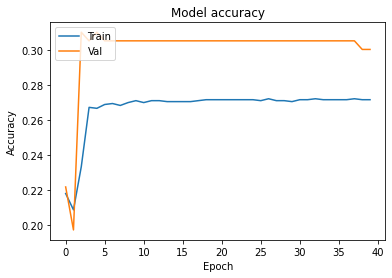

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()